# Relatório sobre ruído em mensagem binária

Aluno: Samuel Lucas Vieira Matos
Matricula: 122110085

## Setup

### Imports

In [279]:
import numpy as np
import matplotlib.pyplot as plt

### Definindo Constantes

In [280]:
# Constantes para configuração
SAMPLE_RATE = 44100  # Taxa de amostragem do audio
BIT_DURATION = 1.0   # 1 segundo por bit
FREQ_LOW = 440       # bit '0' (Lá)
FREQ_HIGH = 880      # bit '1' (Lá oitava)

# Constantes para o problema
DECODED_MSG = "00110000111000000100100111111"

### Definindo funções auxiliares

In [281]:
def generate_tone(frequency, duration, sample_rate=SAMPLE_RATE):
    """
    Gera um tom senoidal
    
    Args:
        frequency: Frequência em Hz
        duration: Duração em segundos
        sample_rate: Taxa de amostragem
    
    Returns:
        array: Sinal de áudio
    """
    t = np.linspace(0, duration, int(sample_rate * duration), False)
    # Aplica janela para suavizar transições
    tone = np.sin(2 * np.pi * frequency * t)
    # Janela de Hanning para evitar cliques
    window = np.hanning(len(tone))
    return tone * window

In [282]:
def show(data:str,debug):
    if debug==True:
        print(data)

In [283]:
def encode_manchester(data_bits,debug=False):
    """
    Codifica dados usando Manchester
    
    Args:
        data_bits: string de bits
    
    Returns:
        array: Sinal de áudio codificado
    """
    audio_signal = np.array([])
    
    show(f"Codificando Manchester: {data_bits}",debug)
    
    for i, bit in enumerate(data_bits):
        if bit == '1':
            # Bit '1': alto->baixo (primeira metade alta, segunda baixa)
            tone1 = generate_tone(FREQ_HIGH, BIT_DURATION/2)
            tone2 = generate_tone(FREQ_LOW, BIT_DURATION/2)
            show(f"Bit {i}: '1' -> {FREQ_HIGH}Hz -> {FREQ_LOW}Hz",debug)
        else:
            # Bit '0': baixo->alto (primeira metade baixa, segunda alta)
            tone1 = generate_tone(FREQ_LOW, BIT_DURATION/2)
            tone2 = generate_tone(FREQ_HIGH, BIT_DURATION/2)
            show(f"Bit {i}: '0' -> {FREQ_LOW}Hz -> {FREQ_HIGH}Hz",debug)
        
        bit_signal = np.concatenate([tone1, tone2])
        audio_signal = np.concatenate([audio_signal, bit_signal])
    
    return audio_signal

In [284]:
def detect_frequency(audio_segment, sample_rate=SAMPLE_RATE):
    """
    Detecta a frequência dominante em um segmento de áudio
    
    Args:
        audio_segment: Segmento de áudio
        sample_rate: Taxa de amostragem
    
    Returns:
        float: Frequência detectada
    """
    # FFT para análise espectral
    fft = np.fft.fft(audio_segment)
    freqs = np.fft.fftfreq(len(fft), 1/sample_rate)
    
    # Considera apenas frequências positivas
    magnitude = np.abs(fft[:len(fft)//2])
    freqs_positive = freqs[:len(freqs)//2]
    
    # Encontra o pico de frequência
    peak_idx = np.argmax(magnitude)
    detected_freq = abs(freqs_positive[peak_idx])
    
    return detected_freq

def frequency_to_bit(frequency, threshold=660):
    """
    Converte frequência detectada em bit
    
    Args:
        frequency: Frequência detectada
        threshold: Limiar para decisão (média entre FREQ_LOW e FREQ_HIGH)
    
    Returns:
        str: '0' ou '1'
    """
    return '1' if frequency > threshold else '0'

def decode_manchester(audio_signal, num_bits, sample_rate=SAMPLE_RATE,debug=False):
    """
    Decodifica sinal Manchester
    """
    samples_per_bit = int(sample_rate * BIT_DURATION)
    decoded_bits = ""
    
    show("Decodificando Manchester:",debug)
    
    for i in range(num_bits):
        start_idx = i * samples_per_bit
        end_idx = start_idx + samples_per_bit
        
        if end_idx > len(audio_signal):
            break
        
        # Analisa primeira e segunda metade do bit
        mid_point = start_idx + samples_per_bit // 2
        
        # Primeira metade
        first_half = audio_signal[start_idx + samples_per_bit//8 : mid_point - samples_per_bit//8]
        freq1 = detect_frequency(first_half, sample_rate)
        state1 = frequency_to_bit(freq1)
        
        # Segunda metade
        second_half = audio_signal[mid_point + samples_per_bit//8 : end_idx - samples_per_bit//8]
        freq2 = detect_frequency(second_half, sample_rate)
        state2 = frequency_to_bit(freq2)
        
        # Determina o bit baseado na transição
        if state1 == '1' and state2 == '0': # Alto -> Baixo
            bit = '1'  
            show(f"Bit {i}: {freq1:.1f}Hz -> {freq2:.1f}Hz = alto->baixo = '1'",debug)
        elif state1 == '0' and state2 == '1': # Baixo -> Alto
            bit = '0'  
            show(f"Bit {i}: {freq1:.1f}Hz -> {freq2:.1f}Hz = baixo->alto = '0'",debug)
        else: # Erro de decodificação
            bit = '?'  
            show(f"Bit {i}: {freq1:.1f}Hz -> {freq2:.1f}Hz = ERRO na transição",debug)
        
        decoded_bits += bit
    
    return decoded_bits

In [285]:
def adicionar_ruido(audio_signal, snr_db=-12):
    """
    Adiciona ruído gaussiano ao sinal
    
    Args:
        audio_signal: Sinal original
        snr_db: Relação sinal-ruído em dB
    
    Returns:
        array: Sinal com ruído
    """
    # Calcula potência do sinal
    signal_power = np.mean(audio_signal ** 2)
    
    # Calcula potência do ruído baseada no SNR
    snr_linear = 10 ** (snr_db / 10)
    noise_power = signal_power / snr_linear
    
    # Gera ruído gaussiano
    noise = np.random.normal(0, np.sqrt(noise_power), len(audio_signal))
    
    return audio_signal + noise

def bits_comprometidos(msg):
    """
    Retorna a quantidade de bits comprometidos da mensagem

    Args:
        msg: Mensagem binária

    Returns:
        int: Quantidade de bits comprometidos
    """

    bits_comprometidos = 0
    for bit in msg:
        if bit == '?': bits_comprometidos += 1
    return bits_comprometidos

## Pegando os dados sobre o rúido da a mensagem "00110000111000000100100111111" do audio 

Pegando a mensagem do áudio "dados_122110085_44100hz.wav"

In [286]:
def aplicar_ruido_sobre_mensagem(decoded_msg):
    msg = encode_manchester(decoded_msg)
    qtd_bits_comprometidos_por_snr = []
    primeiro_bit_comprometido = 0
    snr = 0

    # Inicializa sem ruído
    msg_ruidosa = msg
    while(bits_comprometidos(msg_ruidosa) < len(msg_ruidosa)):
        encoded_msg_ruidosa = adicionar_ruido(msg, snr)
        msg_ruidosa = decode_manchester(encoded_msg_ruidosa, len(msg))

        qtd_bits_comprometidos = bits_comprometidos(msg_ruidosa)
        
        # Pega o primeiro bit comprometido
        # +1 pois a primeira iteração está sendo passada com snr = 0
        if primeiro_bit_comprometido == 0 and qtd_bits_comprometidos > 0:
            primeiro_bit_comprometido = (snr * -1) + 1

        # Pega a quantidade de bits comprometidos por SNR
        qtd_bits_comprometidos_por_snr.append(qtd_bits_comprometidos)
        snr -= 1

    return qtd_bits_comprometidos_por_snr, primeiro_bit_comprometido

## Plotando gráficos - Quantidade de errors X SNR (dB)

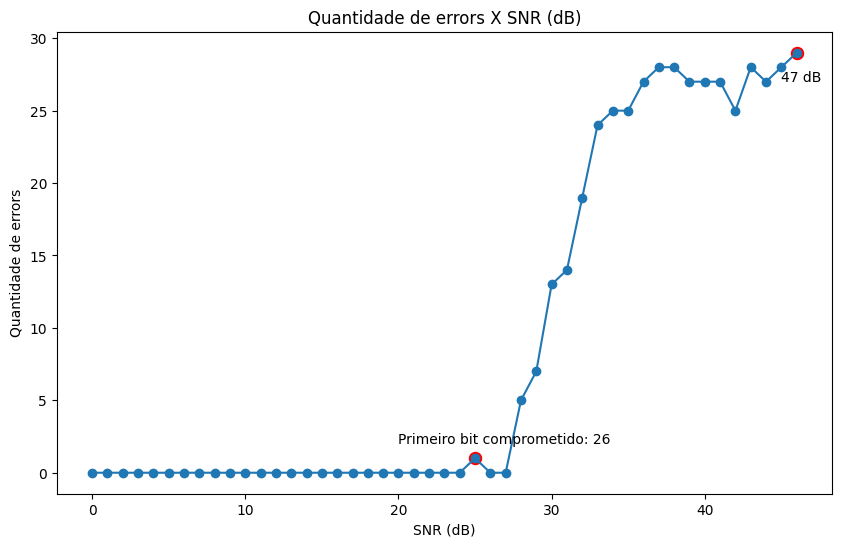

In [287]:
qtd_bits_comprometidos_por_snr, primeiro_bit_comprometido = aplicar_ruido_sobre_mensagem(DECODED_MSG)

plt.figure(figsize=(10, 6))
plt.plot([i for i in range(len(qtd_bits_comprometidos_por_snr))], qtd_bits_comprometidos_por_snr, marker='o', linestyle='-')

# Destacar o ponto de primeiro bit comprometido
plt.scatter(primeiro_bit_comprometido - 1, qtd_bits_comprometidos_por_snr[primeiro_bit_comprometido - 1], color='red', s=75)
plt.annotate(f"Primeiro bit comprometido: {primeiro_bit_comprometido}", xy=(primeiro_bit_comprometido - 1, qtd_bits_comprometidos_por_snr[primeiro_bit_comprometido - 1]), xytext=(primeiro_bit_comprometido - 6, qtd_bits_comprometidos_por_snr[primeiro_bit_comprometido - 1] + 1))

# Destacar o ponto de todos os bits comprometidos
plt.scatter(len(qtd_bits_comprometidos_por_snr)-1, qtd_bits_comprometidos_por_snr[-1], color='red', s=75)
plt.annotate(f"{len(qtd_bits_comprometidos_por_snr)} dB", xy=(len(qtd_bits_comprometidos_por_snr)-1, qtd_bits_comprometidos_por_snr[-1]), xytext=(len(qtd_bits_comprometidos_por_snr)-2, qtd_bits_comprometidos_por_snr[-1] - 2))

# Personalizando o gráfico
plt.title("Quantidade de errors X SNR (dB)")
plt.ylabel("Quantidade de errors")
plt.xlabel("SNR (dB)")

plt.show()

Como podemos ver, a aplicação de ruído usando snr como parâmetro, o `valor de SNR onde os bits começam a ser comprometidos` é **por volta** de `26dB`.

E o `valor de SNR onde os bits estão todos comprometidos` é **por volta** de `47dB`, variando bastante, já que já recebi valores entre `37dB` e `51dB`. Até valores extremos como `72dB`.

Esses valores são estocásticos pois o ruído é gerado aleatoriamente.
